In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

## Data Loading and Cleaning

The dataset contains three subsets. As a first step, we load all datasets and create one pandas dataframe to include all the useful features and information for our project. Given our goal is to forecast 

In [133]:
asset_df = pd.read_csv('assets.txt', sep=",")
events_df = pd.read_csv('events.txt', sep=",")
sale_events_df = pd.read_csv('sale_events.txt', sep=",")

# Change the price formation of total_price to remove redundant 0's for each price
adj_price = []
for i in range(len(sale_events_df)):
    adj_price.append(float(sale_events_df.loc[i]['total_price']) / 10e+18)

sale_events_df.total_price = adj_price

E:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


For asset_df, we drop all the rows that are not an token entry. Since we will just use token_id to join different dataframes, we will drop the "id" column. Additionally, we will drop the "image_url", "permalink" and "collection" columns since they do not add information for our model. 

In [134]:
asset_df_clean = asset_df.drop(asset_df[asset_df.token_id == 'token_id'].index, axis=0)
asset_df_clean = asset_df_clean.drop(labels=['id', 'image_url', 'permalink', 'collection'], axis=1)

For sale_events_df, we will create the average sales price for each token_id and use the price as the target to train the model. Since other informations (except created_date) all have the same value, they do not provide additional information for our forecast and thus are dropped. 

In [140]:
token_id = sale_events_df.token_id.unique()
price_df = pd.DataFrame(columns=['token_id', 'ave_price'])

for i in range(len(token_id)):
    current_token = token_id[i]
    current_price = sale_events_df[sale_events_df.token_id == current_token].total_price.mean()
    price_df.loc[i] = [str(current_token), current_price]

Notice that only a subset of all the items have a transaction price. We merge the price dataframe together with the feature dataframe, keeping only those items with prices. 

In [221]:
price_df['token_id'] = price_df['token_id'].astype(str)
asset_df_clean['token_id'] = asset_df_clean['token_id'].astype(str)
df = price_df.merge(asset_df_clean, on='token_id')
df

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count
0,9932,0.707250,mononoke,237,blue cat skin,9933,buttondown green,220,cool_2,2584,mohawk purple,221
1,9925,0.144000,stunned,247,blue cat skin,9933,hoodie purple,193,cool_1,1979,mohawk purple,221
2,9924,0.174000,sunglasses cool,209,blue cat skin,9933,tshirt pink,203,wild_1,1743,bow,84
3,9923,0.069000,glossy,211,blue cat skin,9933,bandana red,218,cool_1,1979,mohawk purple,221
4,9921,0.131475,angry scar,227,blue cat skin,9933,work blue,198,cool_2,2584,bucket hat green,235
...,...,...,...,...,...,...,...,...,...,...,...,...
844,8951,0.077000,angry cute,250,blue cat skin,9933,astro orange,60,classy_2,747,nurse,81
845,8934,0.266200,sunglasses cool,209,blue cat skin,9933,nurse,60,wild_1,1743,piercings,209
846,8944,0.007000,angry,243,blue cat skin,9933,punk,63,wild_2,1241,sunhat black,105
847,8914,0.203429,ninja black,221,blue cat skin,9933,tanktop white,203,wild_1,1743,helm bronze,66


## Exploratory Data Analysis (EDA)

### Average Price

First, we take a look at the distribution of average transaction price, defined as the average of all the transaction prices during the underlying period. As stated earlier, prices were normalized by dividing by 1e+18 to remove redundant errors at the end. Hereafter, price refers to the normalized price. 

In [167]:
df.ave_price.describe()

count    849.000000
mean       0.258887
std        1.845453
min        0.001000
25%        0.028633
50%        0.090000
75%        0.276000
max       53.406667
Name: ave_price, dtype: float64

We can see that most of the prices are less than 1, but there are a few outliers (such as 53.4). The histogram below shows the distribution of prices (ignoring outliers greater than 1). 

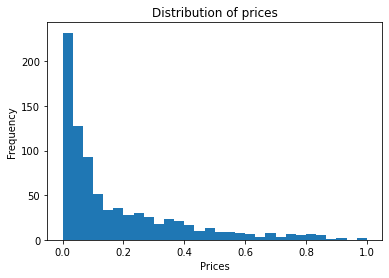

In [170]:
plt.hist(df.ave_price, bins=30, range=(0, 1))
plt.title('Distribution of prices')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

### Features

There are in total five different features: face_value, body_value, shirt_value, tier_value and hat_value, and they are all categorical variables. Since most of the features have many unique values (above 50), showing their relationship with price in a plot is difficult. We will use summary tables to show the average transaction price for each category. For the feature "tier_value", we will show the distribution of price for each category in a box plot. Lastly, since all the samples have "blue cat skin" as their body_value, we ignore the feature body_value in our EDA. 

First, for the feature "face_value", we can see the average transaction prices ranges from 0.08 (for "sunglass cowboy" category) to 0.93 (for "tvface 404" category). The average price for "tired" category is 2.5, which is likely caused by an outlier. 

In [234]:
df.groupby(by='face_value').mean().sort_values(by='ave_price')

,ave_price
face_value,
sunglasses cowboy,0.082845
tvface xp,0.085000
tvface bobross,0.094375
owo,0.101692
sunglasses heart,0.125325
glasses funny,0.137678
uwu,0.145815
sunglasses yellow,0.149023
double face,0.151860


For the feature "shirt_value", the average transaction prices ranges from 0.05 (for "monk" category) to 0.72 (for "robe king" category). The average price for "ninja black" category is 9.33, which is likely caused by an outlier.

In [235]:
df.groupby(by='shirt_value').mean().sort_values(by='ave_price')

,ave_price
shirt_value,
monk,0.052745
overalls yellow,0.052983
cowboy black,0.062329
pirate black,0.064692
knight leather,0.067500
...,...
astro orange,0.433159
astro black,0.441112
combat black,0.471111


For the feature "hats_value", the average transaction prices ranges from 0.01 (for "knight_blue" category) to 0.89 (for "knight black" category). The average price for "flower pink" category is 2.33, which is likely caused by an outlier.

In [236]:
df.groupby(by='hats_value').mean().sort_values(by='ave_price')

,ave_price
hats_value,
knight blue,0.014310
halo,0.022000
visor green,0.044736
deepsea bronze,0.049000
deepsea orange,0.064000
...,...
crown gold,0.548750
costume frog,0.550229
tvhead grey,0.557107


Lastly, below shows the boxplot of each category of the feature "tier_value". We notice that the category "exotic_2" clearly has a higher median than the other categories, and the categories "dassy_1", "dassy_2" and "exotic_2" are more dispersed in price than the other ones. 

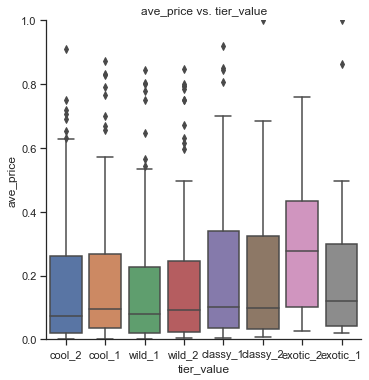

In [233]:
tier_value_plot = sns.catplot(x="tier_value", y="ave_price", kind="box",  data=df)
tier_value_plot.set(ylim=(0, 1))
plt.title('ave_price vs. tier_value')
plt.show()

### Feature Counts

Lastly, we examine if the count for each feature is related to average price, i.e., whether features having more counts are likely to be associated with higher price (possibly due to higher preference/demand for this feature) or lower price (due to less rareness). 

To begin with, we examine the relations between face_count (how many occurance of each face value in the collection) and the average price of each face value. The scatter plot below shows that most of the face values have more than 200 counts, but there is no clear pattern showing higher count would lead to either higher or lower average price. 

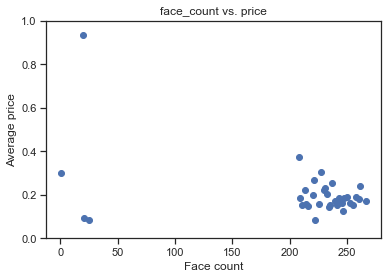

In [252]:
face_count = df.face_count.unique()
price = []
for current_face_count in face_count:
    current_price = df[df.face_count == current_face_count].ave_price.mean()
    price.append(current_price)
face_count = face_count.astype(int)

plt.scatter(x=face_count, y=price)
plt.ylim([0, 1])
plt.title('face_count vs. price')
plt.xlabel('Face count')
plt.ylabel('Average price')
plt.show()

For the relationship between shirt_count and price, it is also not clear if a higher shirt count is associated with a higher or lower average price. 

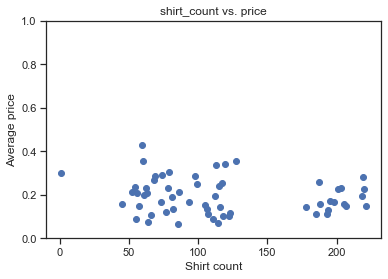

In [253]:
shirt_count = df.shirt_count.unique()
price = []
for current_shirt_count in shirt_count:
    current_price = df[df.shirt_count == current_shirt_count].ave_price.mean()
    price.append(current_price)
shirt_count = shirt_count.astype(int)

plt.scatter(x=shirt_count, y=price)
plt.ylim([0, 1])
plt.title('shirt_count vs. price')
plt.xlabel('Shirt count')
plt.ylabel('Average price')
plt.show()

For the relationship between tier_count and price, it is also not clear if a higher tier count is associated with a higher or lower average price.

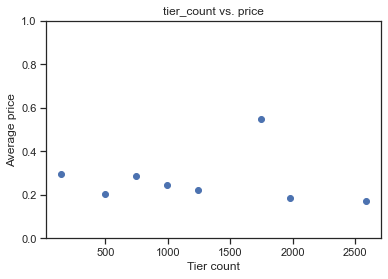

In [254]:
tier_count = df.tier_count.unique()
price = []
for current_tier_count in tier_count:
    current_price = df[df.tier_count == current_tier_count].ave_price.mean()
    price.append(current_price)
tier_count = tier_count.astype(int)

plt.scatter(x=tier_count, y=price)
plt.ylim([0, 1])
plt.title('tier_count vs. price')
plt.xlabel('Tier count')
plt.ylabel('Average price')
plt.show()

Lastly, for the relationship between hats_count and price, there is no clear pattern on whether a higher hats_count is associated with a higher or lower average price. 

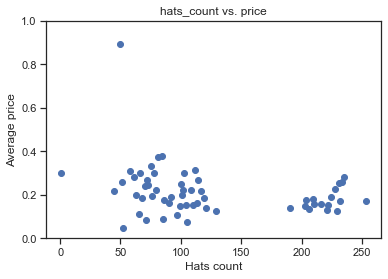

In [255]:
hats_count = df.hats_count.unique()
price = []
for current_hats_count in hats_count:
    current_price = df[df.hats_count == current_hats_count].ave_price.mean()
    price.append(current_price)
hats_count = hats_count.astype(int)

plt.scatter(x=hats_count, y=price)
plt.ylim([0, 1])
plt.title('hats_count vs. price')
plt.xlabel('Hats count')
plt.ylabel('Average price')
plt.show()